<a href="https://colab.research.google.com/github/phelipe-sb/Rain-Prediction/blob/main/Exploratory_Analisis_and_Data_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Calling Libraries and Defining Functions**

In [37]:
pip install scikit-optimize

In [38]:
# GCP Libraries
from google.cloud import bigquery
from google.oauth2 import service_account

# Python libraries
import pandas as pd
from dateutil import relativedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import date
from datetime import datetime
import pickle
 
# Preprocessing
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

# Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Tuning Hyperparameters

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
def gcp_credentials(path):
  credentials = service_account.Credentials.from_service_account_file(path)
  project_id = credentials.project_id
  client = bigquery.Client(project=project_id, credentials=credentials)
  return client, project_id, credentials

In [41]:
def get_table(query_string):
  df = (
    client.query(query_string)
    .result()
    .to_dataframe()
  )
  return df

In [42]:
def cities_filter(df, cidades):
  df = df.loc[df['city'].isin(cidades)]
  df['last_updated'] = pd.to_datetime(df['last_updated'])
  return df

In [43]:
def drop_columns(df, columns):
  df = df.drop(columns)
  df = df.dropna()
  return df

In [44]:
def tag_target(df, raining_list):
  df['target'] = df['condition'].apply(lambda x: 1 if x in raining_list else 0)
  print(df['target'].unique())
  return df

In [45]:
# function to convert columns to float
def to_float(df):
  float_list = list()
  for column_name in df.drop(columns='target').columns:
    if str(df[f'{column_name}'][0]).replace(".", "").replace("-", "").isnumeric() == True:
      float_list.append(column_name)

  for column in df.columns:
    if column in float_list:
      df[f'{column}'] = df[f'{column}'].astype("float")
  return df

In [46]:
def algorithm_columns(df, columns):
  df = df[[columns]]
  return df

In [47]:
# Calculate the difference between the actual and previous register
def date_diff_calc(df):
  df = df.sort_values(by=['city', 'last_updated']).reset_index().drop(columns='index')
  i = 1
  date_diff_list = list()
  for cell in df['last_updated']:
    if i < len(df['last_updated']):
      date_diff_min = (df['last_updated'][i] - cell).total_seconds()/60
      date_diff_list.append(date_diff_min)
      i += 1
  df['date_diff'] = pd.DataFrame(date_diff_list)
  return df

In [48]:
# create a column that tells us weather is raining in the next hour
def rain_next1(df):
  i = 4
  rain_next1 = list()
  for cell in df['target']:
    if i < len(df['target']):
      rain_next1.append(df['target'][i])
      i += 1
  df['target_1'] = pd.DataFrame(rain_next1)
  return df

In [49]:
def split_x_y(df):
  df = df.dropna()
  x = df.drop(columns=['target_1'])
  y = df['target_1']
  return x, y

### **2. Collecting, cleaning and transforming**

In [50]:
client, project_id, credentials = gcp_credentials(path = '/content/drive/MyDrive/Weather_Project/Weather Project-6fa8e059f642.json')

df = get_table(query_string = """
  SELECT *
  FROM (SELECT *
              , ROW_NUMBER() OVER(PARTITION BY last_updated, city ORDER BY last_updated, city) AS row_num
              FROM `weather-project-305419.Daily_Weather.Weather-Info`) as row_weather
  WHERE row_num = 1
  """)

df = cities_filter(df, cidades = ['Paris', 'Sao Paulo', 'Carapicuiba', 'New York', 'Otawwa', 'London', 'Rome', 'Moscow'
          , 'Hong Kong', 'Beijing'])

df = tag_target(df, raining_list = ['Light rain', 'Light rain shower', 'Light drizzle', 'Heavy rain', 'Moderate rain'
  , 'Patchy light rain with thunder', 'Moderate or heavy rain shower', 'Patchy light rain', 'Torrential rain shower'
  , 'Moderate rain at times', 'Moderate or heavy rain with thunder'])

df = to_float(df)

df = date_diff_calc(df)

df = rain_next1(df)

# Transform categorical variables in columns and generate X array
df = df[['city', 'temp_c', 'is_day', 'condition', 'wind_kph', 'wind_degree'
          , 'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feelslike_c', 'vis_km', 'uv'
          , 'gust_kph', 'target', 'target_1']]

x, y = split_x_y(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[0 1]


In [52]:
%cd /content/drive/MyDrive/Weather_Project

/content/drive/MyDrive/Weather_Project


### **3. Data Analysis**

percentage of target == 1 is: 10.0%


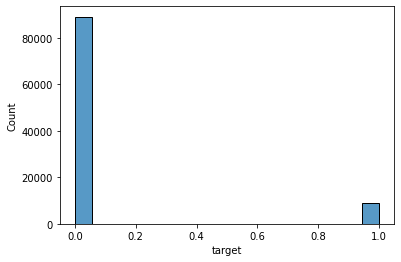

In [53]:
# Target Variable Ocurrency
percent = str(round(sum(df['target'])/len(df['target']), 1)*100) + '%'
print(f'percentage of target == 1 is: {percent}')
sns.histplot(data=df['target'])

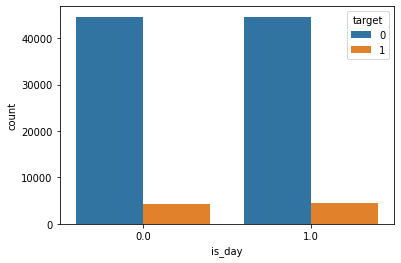

In [54]:
sns.countplot(x=df['is_day'], hue=df['target'])

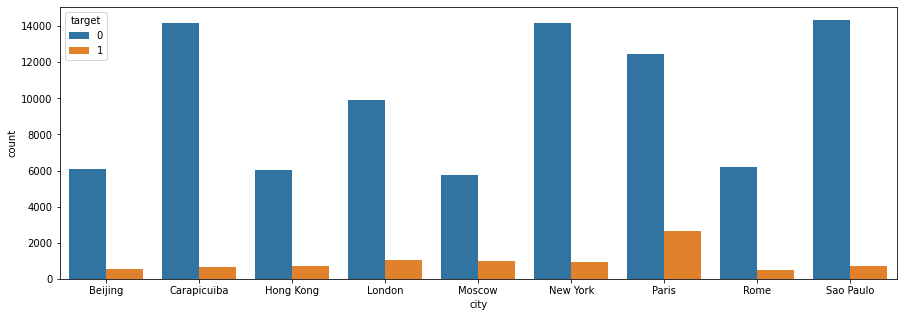

In [55]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x=df['city'], hue=df['target'])

<Figure size 720x360 with 0 Axes>

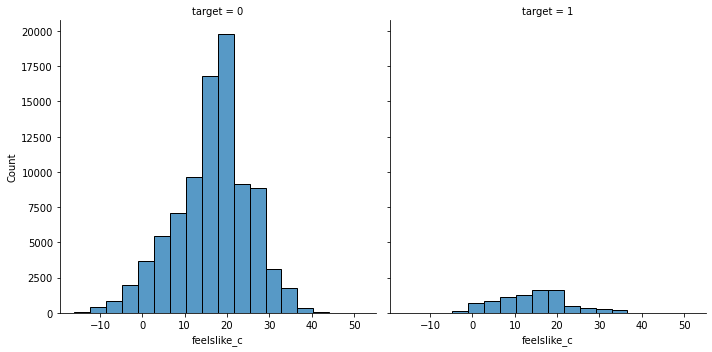

In [56]:
plt.figure(figsize=(10, 5))
ax = sns.displot(x=df['feelslike_c'], bins='sturges', col=df['target'])

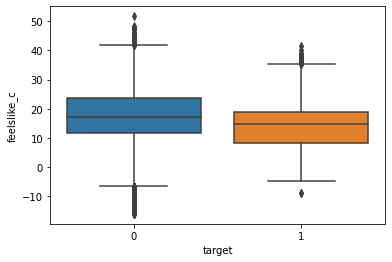

In [57]:
sns.boxplot(x=df['target'], y=df['feelslike_c'])

<Figure size 720x360 with 0 Axes>

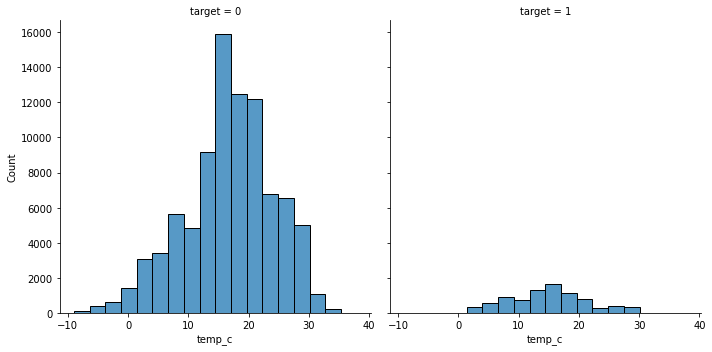

In [58]:
plt.figure(figsize=(10, 5))
ax = sns.displot(x=df['temp_c'], bins='sturges', col=df['target'])

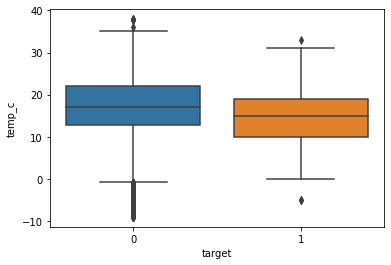

In [59]:
sns.boxplot(x=df['target'], y=df['temp_c'])

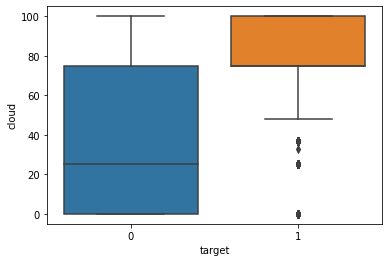

In [60]:
sns.boxplot(x=df['target'], y=df['cloud'])

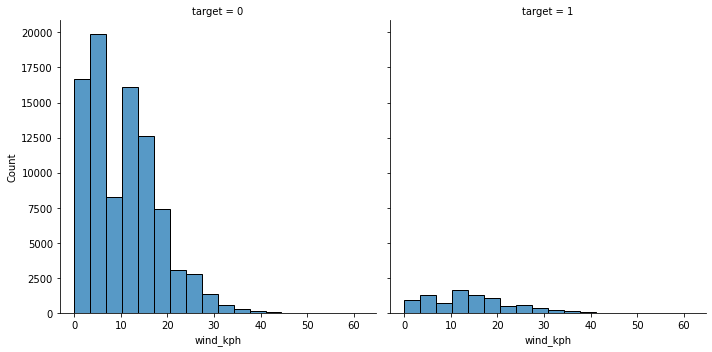

In [61]:
sns.displot(x=df['wind_kph'], col=df['target'], bins='sturges')

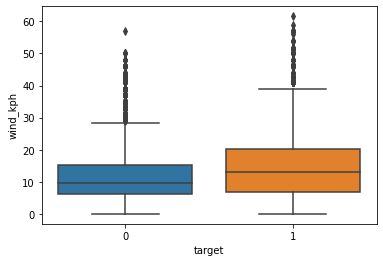

In [62]:
sns.boxplot(x=df['target'], y=df['wind_kph'])

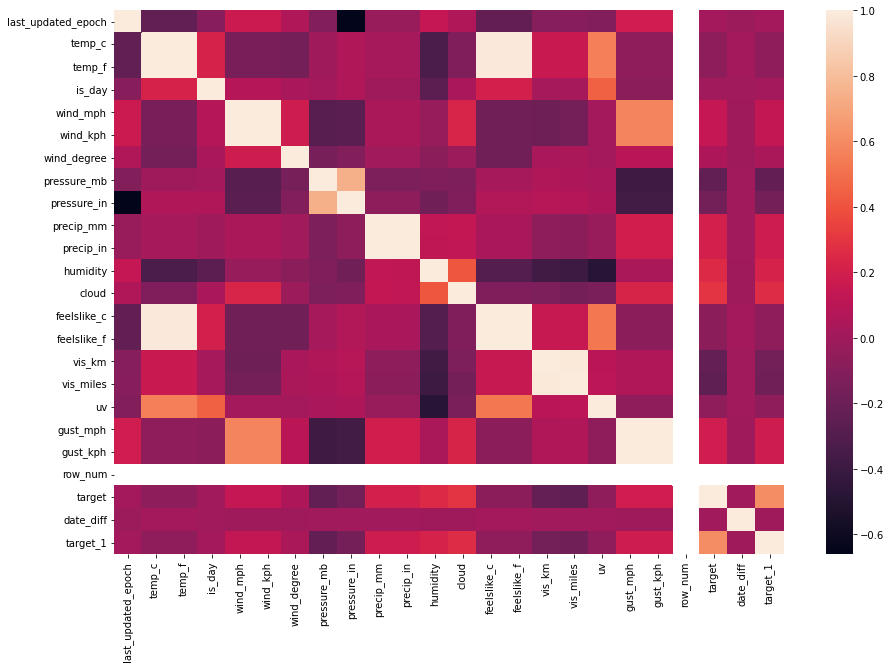

In [63]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr())

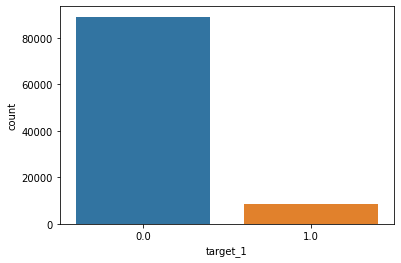

In [64]:
sns.countplot(x=df['target_1'])

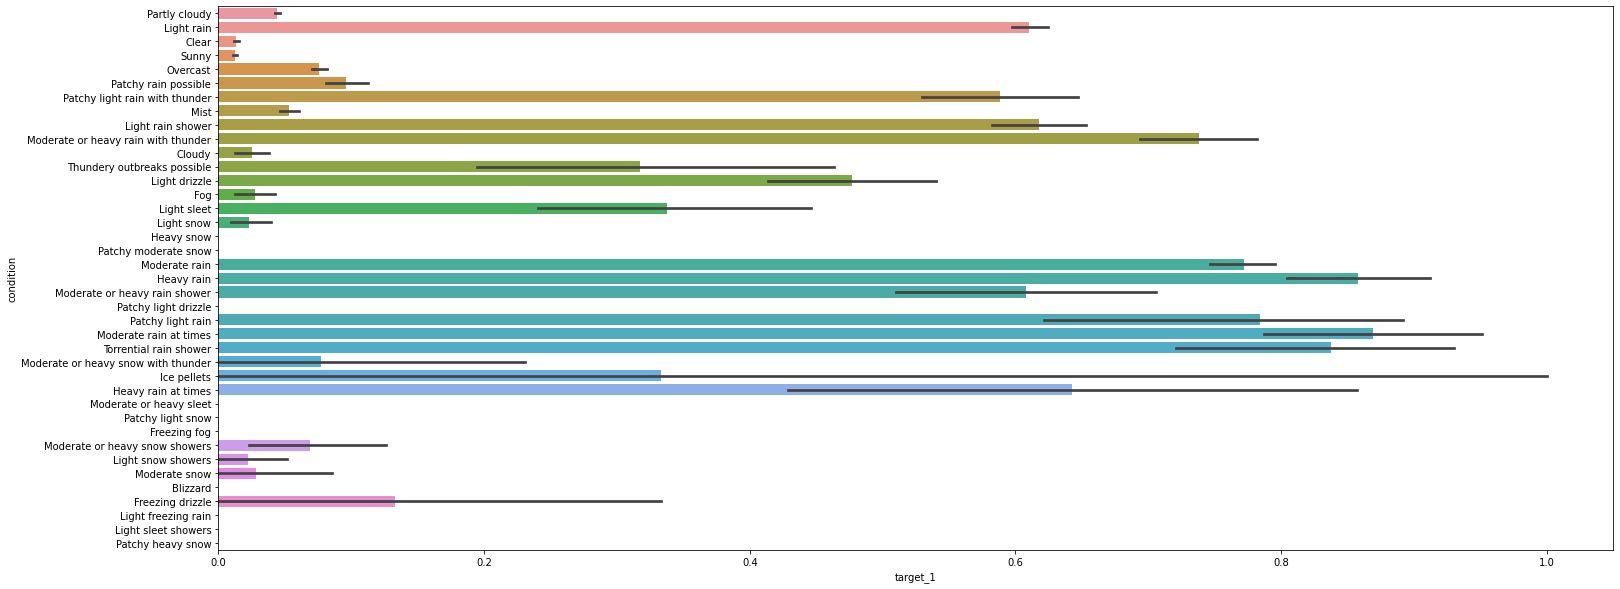

In [65]:
plt.figure(figsize=(25, 10))
sns.barplot(y=df['condition'], x=df['target_1'], orient='horizontal')

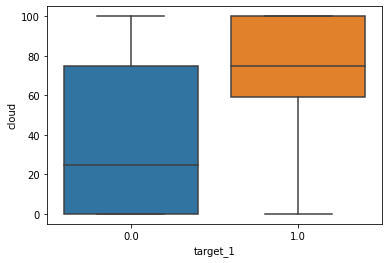

In [66]:
sns.boxplot(y=df['cloud'], x=df['target_1'])

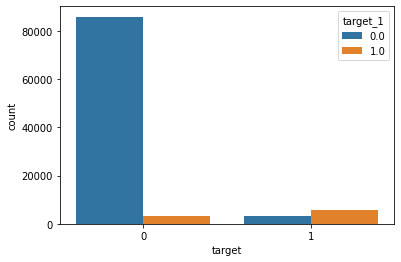

In [67]:
sns.countplot(x=df['target'], hue=df['target_1'])

In [68]:
df.describe()

,last_updated_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feelslike_c,feelslike_f,vis_km,vis_miles,uv,gust_mph,gust_kph,row_num,target,date_diff,target_1
count,9.787100e+04,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.0,97871.000000,97870.000000,97867.000000
mean,1.630463e+09,16.636618,61.946013,0.501006,6.785977,10.914232,163.831707,1016.820018,30.169358,0.262013,0.010129,71.013937,38.607616,16.436316,61.581570,10.187202,5.959079,2.991223,10.091323,16.239476,1.0,0.089363,1.741545,0.089346
std,5.898694e+06,7.310923,13.159785,0.500002,4.931780,7.947392,104.532379,7.638399,0.328624,1.668816,0.065744,18.277906,38.880118,8.841164,15.913406,2.788276,1.640698,2.312982,5.718242,9.202578,0.0,0.285268,2570.890880,0.285244
min,1.619140e+09,-9.000000,15.800000,0.000000,0.000000,0.000000,0.000000,967.000000,28.560000,0.000000,0.000000,8.000000,0.000000,-16.100000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,0.000000,-331725.000000,0.000000
25%,1.625711e+09,12.000000,53.600000,0.000000,3.800000,6.100000,80.000000,1013.000000,29.970000,0.000000,0.000000,60.000000,0.000000,11.100000,51.900000,10.000000,6.000000,1.000000,6.000000,9.700000,1.0,0.000000,15.000000,0.000000
50%,1.631557e+09,17.000000,62.600000,1.000000,6.900000,11.200000,150.000000,1018.000000,30.120000,0.000000,0.000000,75.000000,25.000000,17.000000,62.600000,10.000000,6.000000,1.000000,9.200000,14.800000,1.0,0.000000,15.000000,0.000000
75%,1.635350e+09,21.700000,71.100000,1.000000,9.400000,15.100000,250.000000,1022.000000,30.400000,0.000000,0.000000,87.000000,75.000000,21.700000,71.100000,10.000000,6.000000,5.000000,13.000000,20.900000,1.0,0.000000,15.000000,0.000000
max,1.639005e+09,37.900000,100.200000,1.000000,38.300000,61.600000,360.000000,1044.000000,31.000000,113.800000,4.480000,100.000000,100.000000,51.700000,125.100000,16.000000,9.000000,9.000000,57.700000,92.900000,1.0,1.000000,57645.000000,1.000000


### **5. Finding Best Parameters**

In [115]:
# Numerical
numeric_cols = ['temp_c', 'wind_kph', 'wind_degree', 'pressure_mb', 'precip_mm', 'cloud', 'feelslike_c', 'vis_km'
  , 'uv', 'gust_kph', 'humidity']
  
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

# Categorical
categ_cols = ['condition', 'city', 'is_day', 'target']
categ_transformer = OneHotEncoder(handle_unknown="ignore")

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categ_transformer, categ_cols),
    ],
    remainder='passthrough'
)

In [116]:
lr_search = {
    'model': [LogisticRegression()],
    'model__C': Real(0.01, 1, prior='log-uniform'),
    'model__solver': Categorical(['liblinear']),
    'model__penalty': Categorical(['l1', 'l2']),
    'feature_selection_percentile__percentile': Integer(10, 100)
}

pipe = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("missing_values", SimpleImputer()),
           ("feature_selection_var", VarianceThreshold()),
           ("feature_selection_percentile", SelectPercentile(f_classif)),
           ("model", (LogisticRegression(class_weight='balanced', n_jobs=-1)))]
)

opt_lr = BayesSearchCV(
    pipe,
    [(lr_search, 15)],
    cv=10,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
    
)

opt_lr.fit(x, y)

print("val. score: %s" % opt_lr.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
val. score: 0.8828914970219696


In [117]:
rf_search = {
    'model': [RandomForestClassifier()],
    'model__n_estimators': Integer(50, 500), #prior="log-uniform"),
    'model__max_features': Integer(4, 10),
    #'model__max_leaf_nodes': Integer(2, 1000),
    'model__min_samples_leaf': Integer(50,5000),
    'model__criterion': Categorical(['gini', 'entropy']),
    'feature_selection_percentile__percentile': Integer(50, 90)
}

pipe = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("missing_values", SimpleImputer()),
           ("feature_selection_var", VarianceThreshold()),
           ("feature_selection_percentile", SelectPercentile(f_classif)),
           ("model", (RandomForestClassifier(class_weight='balanced', n_jobs=-1)))]
)

opt = BayesSearchCV(
    pipe,
    [(rf_search, 15)],
    cv=10,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
    
)

opt.fit(x, y)

print("val. score: %s" % opt.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
val. score: 0.902726656557163


In [118]:
xg_search = {
    'model': [GradientBoostingClassifier()],
    'model__loss': Categorical(['deviance', 'exponential']), #prior="log-uniform"),
    'model__learning_rate': Real(0.00001, 0.9, prior='log-uniform'),
    'model__n_estimators': Integer(50, 500),
    'model__subsample': Real(0.1,1, prior='uniform'),
    'model__max_features': Integer(4, 10),
    'model__min_samples_leaf': Integer(50,5000),
    'feature_selection_percentile__percentile': Integer(50, 90)                                   
}

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("smote", SMOTE()),
           ("missing_values", SimpleImputer()),
           ("feature_selection_var", VarianceThreshold()),
           ("feature_selection_percentile", SelectPercentile(f_classif)),
           ("model", (GradientBoostingClassifier()))]
)

opt_xg = BayesSearchCV(
    pipe,
    [(xg_search, 15)],
    cv=10,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
    
)

opt_xg.fit(x, y)

print("val. score: %s" % opt_xg.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
val. score: 0.9010925939321709


In [119]:
print(opt_xg.cv_results_["mean_test_score"].max())
print(opt_xg.cv_results_["std_test_score"].min())
print(opt_xg.best_params_)

0.9010925939321709
0.024368898835803048
OrderedDict([('feature_selection_percentile__percentile', 66), ('model', GradientBoostingClassifier(learning_rate=0.0016268750355587136,
                           loss='exponential', max_features=10,
                           min_samples_leaf=3416, n_estimators=169,
                           subsample=0.1293463547369702)), ('model__learning_rate', 0.0016268750355587136), ('model__loss', 'exponential'), ('model__max_features', 10), ('model__min_samples_leaf', 3416), ('model__n_estimators', 169), ('model__subsample', 0.1293463547369702)])


In [120]:
print(opt_lr.cv_results_["mean_test_score"].max())
print(opt_lr.cv_results_["std_test_score"].min())
print(opt_lr.best_params_)

0.8828914970219696
0.058769725327683306
OrderedDict([('feature_selection_percentile__percentile', 10), ('model', LogisticRegression(C=0.013017697546068492, solver='liblinear')), ('model__C', 0.013017697546068492), ('model__penalty', 'l2'), ('model__solver', 'liblinear')])


In [121]:
print(opt.cv_results_["mean_test_score"].max())
print(opt.cv_results_["std_test_score"].min())
print(opt.best_params_)

0.902726656557163
0.023618286578030487
OrderedDict([('feature_selection_percentile__percentile', 60), ('model', RandomForestClassifier(criterion='entropy', max_features=7,
                       min_samples_leaf=3939, n_estimators=129)), ('model__criterion', 'entropy'), ('model__max_features', 7), ('model__min_samples_leaf', 3939), ('model__n_estimators', 129)])


### **6. Applying Choosed Machine Learning Model**



In [122]:
rf_pipe = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("missing_values", SimpleImputer()),
           ("feature_selection_var", VarianceThreshold()),
           ("feature_selection_percentile", SelectPercentile(f_classif, percentile=60)),
           ("classifier", (RandomForestClassifier(n_jobs=-1, class_weight='balanced',
                                                 criterion='entropy', max_features=10,
                                                 min_samples_leaf=3939, n_estimators=129)))]
)
cross_score = cross_val_score(rf_pipe, x, y, cv=10, scoring='roc_auc', n_jobs=-1)
print(f'cross_mean: {cross_score.mean()}, cross_std: {cross_score.std()}')
rf_pipe.fit(x, y)
y_predict = rf_pipe.predict(x)

cross_mean: 0.9019296469856004, cross_std: 0.026939422454128427


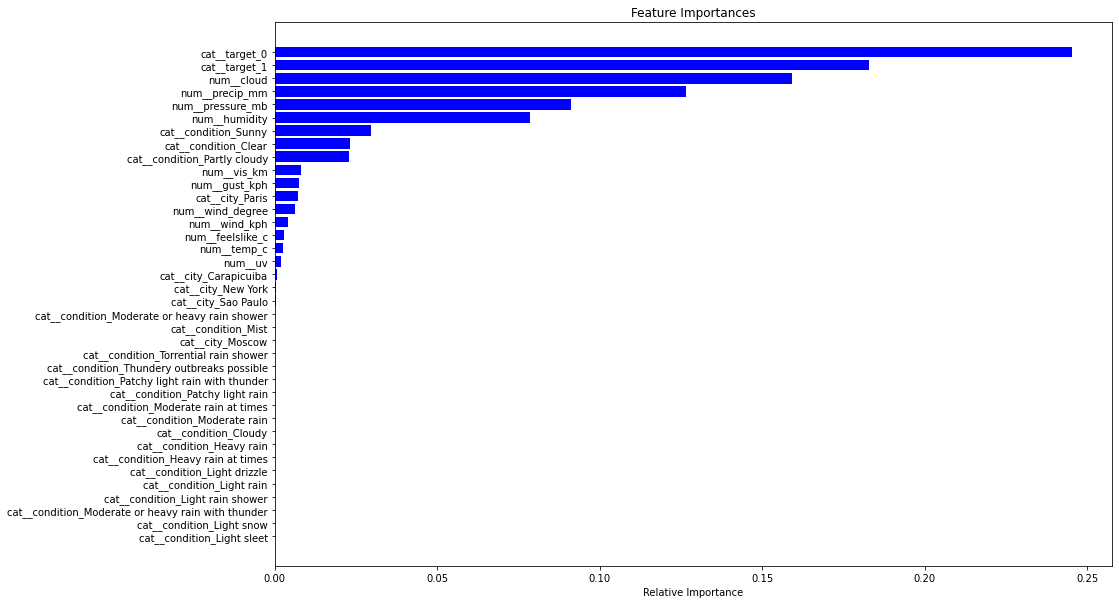

In [123]:
x_features = preprocessor.fit(x).get_feature_names_out()
mask_used_ft = rf_pipe.named_steps['feature_selection_percentile'].get_support()
x_features_used = np.delete((x_features * mask_used_ft), np.where(x_features * mask_used_ft == ""))
importances = rf_pipe.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [x_features_used[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [124]:
f = open('Rain_Model_Object', 'wb')
pickle.dump(rf_pipe, f)
f.close()

In [125]:
df.head()

,city,temp_c,is_day,condition,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feelslike_c,vis_km,uv,gust_kph,target,target_1
0,Beijing,27.0,1.0,Partly cloudy,6.8,140.0,1013.0,1.5,70.0,25.0,31.6,10.0,5.0,5.0,0,0.0
1,Beijing,18.6,1.0,Partly cloudy,6.5,2.0,1011.0,0.0,62.0,9.0,18.6,10.0,5.0,11.9,0,0.0
2,Beijing,21.0,1.0,Light rain,19.1,280.0,1015.0,0.0,73.0,0.0,21.0,10.0,6.0,8.6,1,0.0
3,Beijing,21.0,1.0,Light rain,19.1,280.0,1015.0,0.0,73.0,0.0,21.0,10.0,6.0,8.6,1,0.0
4,Beijing,21.0,0.0,Clear,0.0,221.0,1012.0,0.3,83.0,0.0,21.0,10.0,5.0,9.7,0,0.0
